[View in Colaboratory](https://colab.research.google.com/github/aksh98/Advanced_Biometrics_Assignments/blob/master/BiometricsProject.ipynb)

In [0]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Activation,Dropout,Bidirectional,Flatten,Dense,Conv2D,MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import train_test_split

import os
import numpy as np
import math

In [15]:
#Args - input_tensor=
model = VGG16()

print(model.summary())
# plot_model(model, to_file='vgg.png')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
## ================================================================
## ========= INPUTS ===============================================

def video_to_frames(input_loc, output_loc):
    """    Args:
        input_loc: Input video file.
        output_loc: Output directory to save the frames.
    Returns:
        None
    """
    import time
    import cv2
    import os
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
 
    time_start = time.time()
    
    cap = cv2.VideoCapture(input_loc)
    
    video_length = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        # Write the results back to output location.
        cv2.imwrite(output_loc + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break

## ================================================================





In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpe9wkic6e/pubring.gpg' created
gpg: /tmp/tmpe9wkic6e/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [30]:
%cd drive
%cd Colab Notebooks

[Errno 2] No such file or directory: 'drive'
/content/drive/Colab Notebooks
[Errno 2] No such file or directory: 'Colab Notebooks'
/content/drive/Colab Notebooks


In [31]:
!ls


BiometricsProject.ipynb        full_attributes.txt
BiomProject		       imgarr_13143.pkl
bottleneck_features_test.npy   imgarr_3513.pkl
bottleneck_features_train.npy  imgarr_3788.pkl
BTP_10thApr.ipynb	       IP.ipynb
BTP1.ipynb		       lfw_aligned
btpaligned2		       lfwcolorfaces.zip
btpaligned2.zip		       lfw_crop_A
btpaligned.zip		       __MACOSX
BTP_Apr_16.ipynb	       output1.txt
BTPattributefile.csv	       output21.txt
BTP_Attributes.ods	       output22.txt
btpattributesrefined.csv       output2.txt
btpattributesrefined.csv.ods   output.txt
btpdataset.txt		       tiny_attributes.txt
btpfinalattributes.csv	       tiny_dataset
BTP.ipynb		       Untitled0.ipynb
dlib-19.6		       Untitled1.ipynb
dlib-19.6.tar.bz2	       Untitled2.ipynb
finallala.txt


In [41]:
# X_train, Y_train, X_valid, Y_valid = load_data()
img_width, img_height = 224,224
width_test,ht_test = 224,224
train_data_dir = 'BiomProject/train'
test_data_dir = 'BiomProject/test'

train_samples = 2717
test_samples = 153

# train - 1537 (0-1536) original samples
#         2717 (0-2716)total samples 250*250 - 1180

# test - 0-86 = 87 swapped 
#        87-152 = original 158*215 97*150

epochs = 100

original_len = 1537  
swapped_len = 1180

swapped_test = 87
original_test = 66 

batch_size = 16

# For Theano
# Switch RGB to BGR order 
# x = x[:, ::-1, :, :]
# # Subtract ImageNet mean pixel 
# x[:, :, :, 0] -= 103.939
# x[:, :, :, 1] -= 116.779
# x[:, :, :, 2] -= 123.68

top_model_weights_path = 'BiomProject/bottleneck_model.h5'
weights_path = 'BiomProject/vgg16_weights.h5'

# model_weights_path = 'fc_model.h5'

def save_bottleneck_features():
    model = VGG16(include_top=False, weights = 'imagenet')
    
# Data Augmentation ------------------------------------------
    train_datagen = ImageDataGenerator(
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')
    print("augmentation done1")
    test_datagen = ImageDataGenerator(rescale = 1./255)
#     print("train_Samples",train_samples)
    
# Data Generator --------------------------------------------
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',shuffle=False)

    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (width_test, ht_test),
        batch_size = batch_size, 
        class_mode = None) # yield batches of data, no labels

    train_samples = len(train_generator.filenames)  
    test_samples = len(test_generator.filenames)
    
    print("train_Samples",train_samples)
    print("test_samples",test_samples)
    
    print("data_generated2")
    predict_size_train = int(math.ceil(train_samples / batch_size))
    predict_size_test = int(math.ceil(test_samples / batch_size))
    # if predict_size_test not perfect - give hardcoded input
    bottleneck_features_train = model.predict_generator(train_generator, predict_size_train)
    print("predict_generator1")
    bottleneck_features_test = model.predict_generator(test_generator, predict_size_test)
    print("predict_generator2")
#     np.save(open('bottleneck_features_train.npy','wb'),bottleneck_features_train)
    np.save('bottleneck_features_train',bottleneck_features_train)
    
    np.save('bottleneck_features_test',bottleneck_features_test)
    
#     np.save(open('bottleneck_features_test.npy','wb'),bottleneck_features_test)
    print("bottleneck_features_saved3")
    
save_bottleneck_features()


augmentation done1
Found 2716 images belonging to 2 classes.
Found 152 images belonging to 2 classes.
train_Samples 2716
test_samples 152
data_generated2


KeyboardInterrupt: ignored

In [37]:
##------------------------------------------------------------------------------------------------------------------------------------
##---------REVERSE ENGINEERING-----------------------------------------------------------------------------------------------------------

# X_train, Y_train, X_valid, Y_valid = load_data()
img_width, img_height = 224,224
width_test,ht_test = 224,224
train_data_dir = 'BiomProject/test'
test_data_dir = 'BiomProject/train'

test_samples = 2717
train_samples = 153

# train - 1537 (0-1536) original samples
#         2717 (0-2716)total samples 250*250 - 1180

# test - 0-86 = 87 swapped 
#        87-152 = original 158*215 97*150

epochs = 50

original_test = 1537  
swapped_test = 1180

swapped_len = 87
original_len = 66 

batch_size = 16

# For Theano
# Switch RGB to BGR order 
# x = x[:, ::-1, :, :]
# # Subtract ImageNet mean pixel 
# x[:, :, :, 0] -= 103.939
# x[:, :, :, 1] -= 116.779
# x[:, :, :, 2] -= 123.68

top_model_weights_path = 'BiomProject/bottleneck_model.h5'
weights_path = 'BiomProject/vgg16_weights.h5'

# model_weights_path = 'fc_model.h5'

def save_bottleneck_features():
    model = VGG16(include_top=False, weights = 'imagenet')
    
# Data Augmentation ------------------------------------------
    train_datagen = ImageDataGenerator(
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')
    print("augmentation done1")
    test_datagen = ImageDataGenerator(rescale = 1./255)
#     print("train_Samples",train_samples)
    
# Data Generator --------------------------------------------
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',shuffle=False)

    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (width_test, ht_test),
        batch_size = batch_size, 
        class_mode = None) # yield batches of data, no labels

    train_samples = len(train_generator.filenames)  
    test_samples = len(test_generator.filenames)
    
    print("train_Samples",train_samples)
    print("test_samples",test_samples)
    
    print("data_generated2")
    predict_size_train = int(math.ceil(train_samples / batch_size))
    predict_size_test = int(math.ceil(test_samples / batch_size))
    # if predict_size_test not perfect - give hardcoded input
    bottleneck_features_train = model.predict_generator(train_generator, predict_size_train)
    print("predict_generator1")
    bottleneck_features_test = model.predict_generator(test_generator, predict_size_test)
    print("predict_generator2")
#     np.save(open('bottleneck_features_train.npy','wb'),bottleneck_features_train)
    np.save('bottleneck_features_train',bottleneck_features_train)
    
    np.save('bottleneck_features_test',bottleneck_features_test)
    
#     np.save(open('bottleneck_features_test.npy','wb'),bottleneck_features_test)
    print("bottleneck_features_saved3")
    
save_bottleneck_features()

## ------------------------------------------------------------------------------------------------------------------------------------
##------------------------------------------------------------------------------------------------------------------------------------


augmentation done1
Found 152 images belonging to 2 classes.
Found 2716 images belonging to 2 classes.
train_Samples 152
test_samples 2716
data_generated2
predict_generator1
predict_generator2
bottleneck_features_saved3


(2716, 7, 7, 512)
(152, 7, 7, 512)
fitting :P
Train on 2716 samples, validate on 152 samples
Epoch 1/100
2716/2716 [==============================] - 4s 1ms/step - loss: 0.4063 - acc: 0.9472 - val_loss: 6.2912 - val_acc: 0.5559
Epoch 2/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.1113 - acc: 0.9867 - val_loss: 6.6883 - val_acc: 0.5592
Epoch 3/100
2716/2716 [==============================] - 3s 996us/step - loss: 0.0721 - acc: 0.9906 - val_loss: 6.2720 - val_acc: 0.5493
Epoch 4/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0643 - acc: 0.9921 - val_loss: 6.7629 - val_acc: 0.5526
Epoch 5/100
1840/2716 [===================>..........] - ETA: 0s - loss: 0.0545 - acc: 0.9935

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0491 - acc: 0.9941 - val_loss: 6.8717 - val_acc: 0.5493
Epoch 6/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0339 - acc: 0.9959 - val_loss: 6.8722 - val_acc: 0.5592
Epoch 7/100
2716/2716 [==============================] - 3s 998us/step - loss: 0.0371 - acc: 0.9956 - val_loss: 6.9838 - val_acc: 0.5428
Epoch 8/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0160 - acc: 0.9980 - val_loss: 6.8925 - val_acc: 0.5592
Epoch 9/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0217 - acc: 0.9972 - val_loss: 6.8638 - val_acc: 0.5559
Epoch 10/100
1488/2716 [===============>..............] - ETA: 1s - loss: 0.0348 - acc: 0.9963

2716/2716 [==============================] - 3s 997us/step - loss: 0.0313 - acc: 0.9959 - val_loss: 6.8725 - val_acc: 0.5493
Epoch 11/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0400 - acc: 0.9969 - val_loss: 6.8315 - val_acc: 0.5625
Epoch 12/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0119 - acc: 0.9983 - val_loss: 6.8303 - val_acc: 0.5428
Epoch 13/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0205 - acc: 0.9980 - val_loss: 6.4668 - val_acc: 0.5461
Epoch 14/100
2716/2716 [==============================] - 3s 999us/step - loss: 0.0100 - acc: 0.9991 - val_loss: 6.7703 - val_acc: 0.5592
Epoch 15/100
1312/2716 [=============>................] - ETA: 1s - loss: 0.0100 - acc: 0.9985

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0097 - acc: 0.9987 - val_loss: 6.6834 - val_acc: 0.5428
Epoch 16/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0179 - acc: 0.9982 - val_loss: 6.7416 - val_acc: 0.5329
Epoch 17/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0087 - acc: 0.9989 - val_loss: 6.9565 - val_acc: 0.5493
Epoch 18/100
2716/2716 [==============================] - 3s 996us/step - loss: 0.0079 - acc: 0.9989 - val_loss: 7.0671 - val_acc: 0.5493
Epoch 19/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0010 - acc: 0.9996 - val_loss: 6.9454 - val_acc: 0.5461
Epoch 20/100
1552/2716 [================>.............] - ETA: 1s - loss: 0.0055 - acc: 0.9990

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0031 - acc: 0.9994 - val_loss: 7.0189 - val_acc: 0.5461
Epoch 21/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0134 - acc: 0.9978 - val_loss: 6.9938 - val_acc: 0.5461
Epoch 22/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0295 - acc: 0.9967 - val_loss: 6.9477 - val_acc: 0.5493
Epoch 23/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0068 - acc: 0.9994 - val_loss: 7.0535 - val_acc: 0.5526
Epoch 24/100
2716/2716 [==============================] - 3s 993us/step - loss: 0.0125 - acc: 0.9987 - val_loss: 6.6819 - val_acc: 0.5493
Epoch 25/100
1520/2716 [===============>..............] - ETA: 1s - loss: 1.0983e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0019 - acc: 0.9998 - val_loss: 6.8547 - val_acc: 0.5493
Epoch 26/100
2716/2716 [==============================] - 3s 994us/step - loss: 5.3261e-04 - acc: 0.9996 - val_loss: 6.9350 - val_acc: 0.5559
Epoch 27/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0036 - acc: 0.9996 - val_loss: 6.9496 - val_acc: 0.5592
Epoch 28/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 6.9717 - val_acc: 0.5559
Epoch 29/100
2716/2716 [==============================] - 3s 999us/step - loss: 0.0021 - acc: 0.9994 - val_loss: 6.9499 - val_acc: 0.5559
Epoch 30/100
1408/2716 [==============>...............] - ETA: 1s - loss: 0.0173 - acc: 0.9986

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0107 - acc: 0.9991 - val_loss: 6.9261 - val_acc: 0.5592
Epoch 31/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0135 - acc: 0.9985 - val_loss: 6.5568 - val_acc: 0.5592
Epoch 32/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0046 - acc: 0.9993 - val_loss: 6.7159 - val_acc: 0.5625
Epoch 33/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0079 - acc: 0.9991 - val_loss: 6.7163 - val_acc: 0.5592
Epoch 34/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0032 - acc: 0.9994 - val_loss: 6.8914 - val_acc: 0.5493
Epoch 35/100
1424/2716 [==============>...............] - ETA: 1s - loss: 0.0023 - acc: 0.9996

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0054 - acc: 0.9993 - val_loss: 6.8902 - val_acc: 0.5493
Epoch 36/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0117 - acc: 0.9993 - val_loss: 6.9282 - val_acc: 0.5461
Epoch 37/100
2716/2716 [==============================] - 3s 1ms/step - loss: 2.4088e-07 - acc: 1.0000 - val_loss: 6.9063 - val_acc: 0.5395
Epoch 38/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0025 - acc: 0.9994 - val_loss: 6.9608 - val_acc: 0.5559
Epoch 39/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0037 - acc: 0.9994 - val_loss: 6.9132 - val_acc: 0.5592
Epoch 40/100
1184/2716 [============>.................] - ETA: 1s - loss: 0.0024 - acc: 0.9996

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0020 - acc: 0.9996 - val_loss: 6.8191 - val_acc: 0.5428
Epoch 41/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0033 - acc: 0.9993 - val_loss: 6.5770 - val_acc: 0.5428
Epoch 42/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0114 - acc: 0.9993 - val_loss: 6.6811 - val_acc: 0.5461
Epoch 43/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0035 - acc: 0.9996 - val_loss: 6.4829 - val_acc: 0.5428
Epoch 44/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0033 - acc: 0.9994 - val_loss: 6.5592 - val_acc: 0.5526
Epoch 45/100
1056/2716 [==========>...................] - ETA: 1s - loss: 1.5394e-06 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0059 - acc: 0.9996 - val_loss: 6.5269 - val_acc: 0.5493
Epoch 46/100
2716/2716 [==============================] - 3s 999us/step - loss: 0.0072 - acc: 0.9993 - val_loss: 6.6820 - val_acc: 0.5395
Epoch 47/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0106 - acc: 0.9987 - val_loss: 6.5841 - val_acc: 0.5428
Epoch 48/100
2716/2716 [==============================] - 3s 997us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 6.5186 - val_acc: 0.5493
Epoch 49/100
2716/2716 [==============================] - 3s 990us/step - loss: 0.0023 - acc: 0.9998 - val_loss: 6.6733 - val_acc: 0.5428
Epoch 50/100
1328/2716 [=============>................] - ETA: 1s - loss: 0.0055 - acc: 0.9996

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0086 - acc: 0.9994 - val_loss: 6.7064 - val_acc: 0.5559
Epoch 51/100
2716/2716 [==============================] - 3s 1ms/step - loss: 4.9411e-04 - acc: 0.9998 - val_loss: 6.7671 - val_acc: 0.5395
Epoch 52/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.0960e-07 - acc: 1.0000 - val_loss: 6.7473 - val_acc: 0.5362
Epoch 53/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.0965e-07 - acc: 1.0000 - val_loss: 6.7564 - val_acc: 0.5395
Epoch 54/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.2374e-07 - acc: 1.0000 - val_loss: 6.7762 - val_acc: 0.5428
Epoch 55/100
 992/2716 [=========>....................] - ETA: 1s - loss: 1.0960e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 6.8468e-07 - acc: 1.0000 - val_loss: 6.7941 - val_acc: 0.5526
Epoch 56/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.6571e-04 - acc: 0.9998 - val_loss: 6.6868 - val_acc: 0.5395
Epoch 57/100
2716/2716 [==============================] - 3s 994us/step - loss: 0.0026 - acc: 0.9996 - val_loss: 6.6615 - val_acc: 0.5428
Epoch 58/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.1436e-07 - acc: 1.0000 - val_loss: 6.6539 - val_acc: 0.5395
Epoch 59/100
2716/2716 [==============================] - 3s 995us/step - loss: 1.1278e-07 - acc: 1.0000 - val_loss: 6.7023 - val_acc: 0.5428
Epoch 60/100
1168/2716 [===========>..................] - ETA: 1s - loss: 7.4084e-05 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 6.6144 - val_acc: 0.5461
Epoch 61/100
2716/2716 [==============================] - 3s 1ms/step - loss: 9.5500e-06 - acc: 1.0000 - val_loss: 6.6495 - val_acc: 0.5395
Epoch 62/100
2716/2716 [==============================] - 3s 1ms/step - loss: 4.0868e-04 - acc: 0.9998 - val_loss: 6.6338 - val_acc: 0.5395
Epoch 63/100
2716/2716 [==============================] - 3s 1000us/step - loss: 2.9269e-06 - acc: 1.0000 - val_loss: 6.7872 - val_acc: 0.5329
Epoch 64/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0034 - acc: 0.9996 - val_loss: 6.6370 - val_acc: 0.5691
Epoch 65/100
1056/2716 [==========>...................] - ETA: 1s - loss: 1.2414e-06 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 1.8505e-06 - acc: 1.0000 - val_loss: 6.6646 - val_acc: 0.5592
Epoch 66/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 6.6975 - val_acc: 0.5526
Epoch 67/100
2716/2716 [==============================] - 3s 995us/step - loss: 0.0040 - acc: 0.9994 - val_loss: 6.6524 - val_acc: 0.5625
Epoch 68/100
2716/2716 [==============================] - 3s 1ms/step - loss: 4.2488e-05 - acc: 1.0000 - val_loss: 6.6323 - val_acc: 0.5691
Epoch 69/100
2716/2716 [==============================] - 3s 999us/step - loss: 8.7735e-04 - acc: 0.9998 - val_loss: 6.7781 - val_acc: 0.5625
Epoch 70/100
1264/2716 [============>.................] - ETA: 1s - loss: 1.0960e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 6.7859 - val_acc: 0.5592
Epoch 71/100
2716/2716 [==============================] - 3s 1ms/step - loss: 2.8331e-07 - acc: 1.0000 - val_loss: 6.8786 - val_acc: 0.5625
Epoch 72/100
2716/2716 [==============================] - 3s 1ms/step - loss: 8.8243e-04 - acc: 0.9998 - val_loss: 6.8107 - val_acc: 0.5658
Epoch 73/100
2716/2716 [==============================] - 3s 1ms/step - loss: 2.2495e-04 - acc: 0.9998 - val_loss: 6.8685 - val_acc: 0.5559
Epoch 74/100
2716/2716 [==============================] - 3s 1ms/step - loss: 2.5189e-07 - acc: 1.0000 - val_loss: 6.7671 - val_acc: 0.5658
Epoch 75/100
1152/2716 [===========>..................] - ETA: 1s - loss: 0.0020 - acc: 0.9996

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0066 - acc: 0.9993 - val_loss: 6.9707 - val_acc: 0.5559
Epoch 76/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0029 - acc: 0.9998 - val_loss: 6.8487 - val_acc: 0.5559
Epoch 77/100
2716/2716 [==============================] - 3s 1ms/step - loss: 5.9347e-06 - acc: 1.0000 - val_loss: 6.9237 - val_acc: 0.5559
Epoch 78/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.0960e-07 - acc: 1.0000 - val_loss: 6.8799 - val_acc: 0.5559
Epoch 79/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0060 - acc: 0.9996 - val_loss: 6.9909 - val_acc: 0.5559
Epoch 80/100
1104/2716 [===========>..................] - ETA: 1s - loss: 1.9860e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0047 - acc: 0.9996 - val_loss: 7.0550 - val_acc: 0.5526
Epoch 81/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0045 - acc: 0.9996 - val_loss: 6.9997 - val_acc: 0.5526
Epoch 82/100
2716/2716 [==============================] - 3s 1ms/step - loss: 2.3598e-05 - acc: 1.0000 - val_loss: 6.9949 - val_acc: 0.5526
Epoch 83/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0063 - acc: 0.9994 - val_loss: 6.9587 - val_acc: 0.5493
Epoch 84/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.0965e-07 - acc: 1.0000 - val_loss: 6.9942 - val_acc: 0.5461
Epoch 85/100
1152/2716 [===========>..................] - ETA: 1s - loss: 1.1691e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 991us/step - loss: 1.1280e-07 - acc: 1.0000 - val_loss: 6.9802 - val_acc: 0.5493
Epoch 86/100
2716/2716 [==============================] - 3s 1ms/step - loss: 9.0764e-04 - acc: 0.9998 - val_loss: 7.0263 - val_acc: 0.5559
Epoch 87/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0023 - acc: 0.9996 - val_loss: 7.0358 - val_acc: 0.5526
Epoch 88/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0040 - acc: 0.9994 - val_loss: 7.0300 - val_acc: 0.5461
Epoch 89/100
2716/2716 [==============================] - 3s 1ms/step - loss: 7.7239e-05 - acc: 1.0000 - val_loss: 7.0446 - val_acc: 0.5461
Epoch 90/100
1120/2716 [===========>..................] - ETA: 1s - loss: 0.0107 - acc: 0.9991

2716/2716 [==============================] - 3s 1ms/step - loss: 0.0103 - acc: 0.9993 - val_loss: 6.8999 - val_acc: 0.5625
Epoch 91/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0024 - acc: 0.9998 - val_loss: 6.9061 - val_acc: 0.5592
Epoch 92/100
2716/2716 [==============================] - 3s 1ms/step - loss: 4.0482e-07 - acc: 1.0000 - val_loss: 6.9222 - val_acc: 0.5559
Epoch 93/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0030 - acc: 0.9998 - val_loss: 6.9875 - val_acc: 0.5559
Epoch 94/100
2716/2716 [==============================] - 3s 1ms/step - loss: 1.2131e-07 - acc: 1.0000 - val_loss: 7.0003 - val_acc: 0.5559
Epoch 95/100
1168/2716 [===========>..................] - ETA: 1s - loss: 6.0255e-07 - acc: 1.0000

2716/2716 [==============================] - 3s 1ms/step - loss: 3.2159e-07 - acc: 1.0000 - val_loss: 6.9403 - val_acc: 0.5559
Epoch 96/100
2716/2716 [==============================] - 3s 998us/step - loss: 0.0118 - acc: 0.9993 - val_loss: 6.9528 - val_acc: 0.5559
Epoch 97/100
2716/2716 [==============================] - 3s 999us/step - loss: 0.0011 - acc: 0.9998 - val_loss: 7.0524 - val_acc: 0.5493
Epoch 98/100
2716/2716 [==============================] - 3s 1ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 7.0962 - val_acc: 0.5493
Epoch 99/100
2716/2716 [==============================] - 3s 989us/step - loss: 0.0071 - acc: 0.9994 - val_loss: 7.1081 - val_acc: 0.5493
Epoch 100/100
1248/2716 [============>.................] - ETA: 1s - loss: 1.0960e-07 - acc: 1.0000

152/152 [==============================] - 0s 594us/step
0.5493421052631579


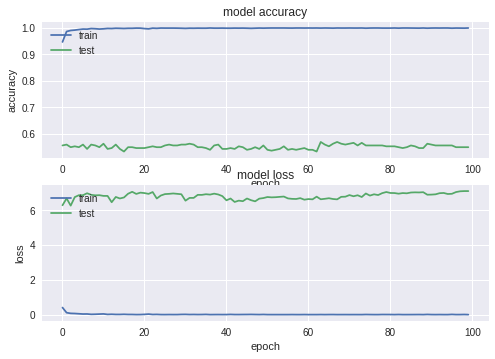

In [43]:
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from keras.utils import to_categorical

original_len = 1536  
swapped_len = 1180

swapped_test = 86
original_test = 66 

def train_top_model():
    
#     train_data = np.load(open('bottleneck_features_train.npy','wb'))
#     test_data = np.load(open('bottleneck_features_test.npy','wb'))
    train_data = np.load('bottleneck_features_train.npy')
    test_data = np.load('bottleneck_features_test.npy')
    print(train_data.shape)
    print(test_data.shape)
    
    
    ####  CHANGE THISSSSS -------------------
    
    train_labels = np.array([1]*original_len + [0]*swapped_len).astype('float32')
    encoded_train = to_categorical(train_labels)
    test_labels = np.array([1]*original_test + [0]*swapped_test).astype('float32')
    encoded_test = to_categorical(test_labels)
    
    
    ##### -----------------------------------
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation = 'sigmoid'))
    

    model.compile(loss='binary_crossentropy',
          optimizer='rmsprop',
          metrics=['accuracy'])
    
    print("fitting :P")
    history = model.fit(train_data,encoded_train,
             epochs=epochs,batch_size = batch_size,validation_data=(test_data,encoded_test))
    
    model.save_weights(top_model_weights_path)
    
    (eval_loss,eval_accuracy) = model.evaluate(test_data,encoded_test,batch_size=batch_size,verbose=1)
    
    print(eval_accuracy)
    
    plt.figure(1)  
    
     # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

     # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()
    
#     np.save('class_indices.npy',generator_top.class_indices)
    
    
#     model.fit_generator(
#         train_generator,
#         steps_per_epoch= train_samples // batch_size,
#         epochs=epochs,
#         validation_data= test_generator,
#         validation_steps= test_samples // batch_size)
   

train_top_model()
# fine_tune()



(152, 7, 7, 512)
(2716, 7, 7, 512)
heylp
Epoch 1/50
152/152 [==============================] - 1s 7ms/step - loss: 3.3162 - acc: 0.6316
Epoch 2/50
152/152 [==============================] - 0s 1ms/step - loss: 1.6786 - acc: 0.8092
Epoch 3/50
152/152 [==============================] - 0s 1ms/step - loss: 0.8059 - acc: 0.9079
Epoch 4/50
152/152 [==============================] - 0s 1ms/step - loss: 0.2680 - acc: 0.9605
Epoch 5/50
152/152 [==============================] - 0s 1ms/step - loss: 0.2668 - acc: 0.9704
Epoch 6/50
152/152 [==============================] - 0s 1ms/step - loss: 0.2602 - acc: 0.9671
Epoch 7/50
152/152 [==============================] - 0s 1ms/step - loss: 0.3920 - acc: 0.9572
Epoch 8/50
152/152 [==============================] - 0s 1ms/step - loss: 0.4729 - acc: 0.9507
Epoch 9/50
152/152 [==============================] - 0s 1ms/step - loss: 0.1668 - acc: 0.9770
Epoch 10/50
152/152 [==============================] - 0s 1ms/step - loss: 0.3376 - acc: 0.9704
Epoch 11

Epoch 22/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0124 - acc: 0.9967
Epoch 23/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0943 - acc: 0.9901
Epoch 24/50
152/152 [==============================] - 0s 1ms/step - loss: 4.7900e-04 - acc: 1.0000
Epoch 25/50
152/152 [==============================] - 0s 1ms/step - loss: 0.1128 - acc: 0.9836
Epoch 26/50
152/152 [==============================] - 0s 1ms/step - loss: 0.1288 - acc: 0.9868
Epoch 27/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0037 - acc: 1.0000
Epoch 28/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0350 - acc: 0.9967
Epoch 29/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0098 - acc: 0.9967
Epoch 30/50
152/152 [==============================] - 0s 1ms/step - loss: 1.0575e-04 - acc: 1.0000
Epoch 31/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0030 - acc: 0.9967
Epoch 32/50
152/152 [===========

152/152 [==============================] - 0s 1ms/step - loss: 4.9476e-04 - acc: 1.0000
Epoch 43/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0169 - acc: 0.9967
Epoch 44/50
152/152 [==============================] - 0s 1ms/step - loss: 0.1043 - acc: 0.9868
Epoch 45/50
152/152 [==============================] - 0s 1ms/step - loss: 1.9724e-04 - acc: 1.0000
Epoch 46/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0531 - acc: 0.9967
Epoch 47/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0198 - acc: 0.9967
Epoch 48/50
152/152 [==============================] - 0s 1ms/step - loss: 0.0430 - acc: 0.9967
Epoch 49/50
152/152 [==============================] - 0s 1ms/step - loss: 6.2599e-06 - acc: 1.0000
Epoch 50/50
2716/2716 [==============================] - 2s 634us/step
0.44164212067804914


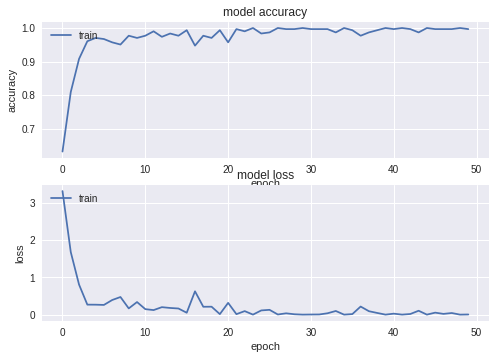

In [39]:
##-----------------------------------------------------------------------------------------------------------------------------------
##------------------------------------------------------------------------------------------------------------------------------------
## ------------------------------------------------------------------------------------------------------------------------------------
##------------------------------------------------------------------------------------------------------------------------------------

from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from keras.utils import to_categorical

original_test = 1536  
swapped_test = 1180

swapped_len = 86
original_len = 66 

def train_top_model():
    
#     train_data = np.load(open('bottleneck_features_train.npy','wb'))
#     test_data = np.load(open('bottleneck_features_test.npy','wb'))
    train_data = np.load('bottleneck_features_train.npy')
    test_data = np.load('bottleneck_features_test.npy')
    print(train_data.shape)
    print(test_data.shape)
    
    
    ####  CHANGE THISSSSS -------------------
    
    train_labels = np.array([1]*original_len + [0]*swapped_len).astype('float32')
    encoded_train = to_categorical(train_labels)
    test_labels = np.array([1]*original_test + [0]*swapped_test).astype('float32')
    encoded_test = to_categorical(test_labels)
    
    
    ##### -----------------------------------
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation = 'sigmoid'))
    

    model.compile(loss='binary_crossentropy',
          optimizer='rmsprop',
          metrics=['accuracy'])
    
    print("heylp")
    history = model.fit(train_data,encoded_train,
             epochs=epochs,batch_size = batch_size)
    
    model.save_weights(top_model_weights_path)
    
    (eval_loss,eval_accuracy) = model.evaluate(test_data,encoded_test,batch_size=batch_size,verbose=1)
    print(eval_accuracy)
    plt.figure(1)  
    
     # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['acc'])  
#     plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

     # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history['loss'])  
#     plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()
  
train_top_model()
## ------------------------------------------------------------------------------------------------------------------------------------
##------------------------------------------------------------------------------------------------------------------------------------
## ------------------------------------------------------------------------------------------------------------------------------------
##------------------------------------------------------------------------------------------------------------------------------------


In [0]:
    model = VGG16(weights='imagenet',include_top=False)
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape = model.output_shape[1:]))
    top_model.add(Dense(256,activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1,activation='sigmoid'))
    
    top_model.load_weights(top_model_weights_path)
    
    model.add(top_model)
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='binary_crossentropy',
                 optimizer=optimizers.SGD(lr=0.0001,momentum=0.9),
                 metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
          zoom_range=0.2,
          shear_range=0.2,
          horizontal_flip=True,
          height_shift_range = 0.2,
          width_shift_range = 0.2,
          fill_mode='nearest')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                      target_size = (img_height,img_width),
                      batch_size = batch_size,class_mode='binary')
    
    test_generator = test_datagen.flow_from_directory(test_data_dir,
                      target_size = (ht_test,width_test),
                      batch_size = batch_size,class_mode='binary')
    
    train_samples = len(train_generator.filenames)  
    test_samples = len(test_generator.filenames)
    
    model.fit_generator(
        train_generator,
        samples_per_epoch=train_samples,
        epochs=epochs,
        validation_data=test_generator,
        nb_val_samples=test_samples)
     
fine_tune()